In [9]:
import yfinance as yf
import numpy as np
import ta
import pandas as pd  

def get_stock_data(ticker_symbol, period='20y', interval='1d'):
    # Fetch data for the last 20 years
    data = yf.download(ticker_symbol, period=period, interval=interval)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    predict_data = data[columns].copy()
    predict_data.reset_index(drop=True, inplace=True)

    predict_data.columns = ['open', 'high', 'low', 'close', 'volume']
    df = predict_data

    # Existing indicators
    df['OBV'] = ta.volume.on_balance_volume(df['close'], df['volume'])
    df['macd_DIF'] = ta.trend.macd_diff(df['close'])
    df['macd_SIGNAL'] = ta.trend.macd_signal(df['close'])
    df['macd_HIST'] = ta.trend.macd_diff(df['close'])
    df['EMA5'] = ta.trend.ema_indicator(df['close'], window=5)
    df['EMA10'] = ta.trend.ema_indicator(df['close'], window=10)
    df['EMA25'] = ta.trend.ema_indicator(df['close'], window=25)
    df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)
    df['rsi_9'] = ta.momentum.rsi(df['close'], window=9)
    df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)
    stochastic = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['stoch_%K'] = stochastic.stoch()
    df['stoch_%D'] = stochastic.stoch_signal()
    bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_%b'] = bb.bollinger_pband()  # %B indicator
    df['bb_width'] = bb.bollinger_wband()  # Bandwidth
    adx_ind = ta.trend.ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['ADX'] = adx_ind.adx()
    df['DMP'] = adx_ind.adx_pos()  # +DI
    df['DMN'] = adx_ind.adx_neg()  # -DI
    df['CCI'] = ta.trend.cci(high=df['high'], low=df['low'], close=df['close'], window=20)
    df['williams_%R'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=14)
    df['CMF'] = ta.volume.chaikin_money_flow(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=20)
    df['MFI'] = ta.volume.money_flow_index(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=14)
    df['ROC'] = ta.momentum.roc(close=df['close'], window=14)
    df['TRIX'] = ta.trend.trix(close=df['close'], window=15)
    keltner = ta.volatility.KeltnerChannel(high=df['high'], low=df['low'], close=df['close'], window=20, window_atr=10)
    df['keltner_ma'] = keltner.keltner_channel_mband()
    df['keltner_upper'] = keltner.keltner_channel_hband()
    df['keltner_lower'] = keltner.keltner_channel_lband()
    df['VWAP'] = ta.volume.volume_weighted_average_price(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=20)
    donchian = ta.volatility.DonchianChannel(high=df['high'], low=df['low'], close=df['close'], window=20)
    df['donchian_upper'] = donchian.donchian_channel_hband()
    df['donchian_lower'] = donchian.donchian_channel_lband()
    df['std_dev'] = df['close'].rolling(window=20).std()
    
    new_order=['macd_DIF', 'macd_SIGNAL', 'macd_HIST', 'EMA5', 'EMA10', 'EMA25', 'rsi_14', 'rsi_9', 'stoch_%K', 'stoch_%D', 'bb_%b', 'DMP', 'CMF', 'ROC', 'TRIX', 'williams_%R']
    df = df[new_order]
    # Return training data starting from index 50 to ensure all indicators have values
    training_data = df.loc[50:]
    return training_data



### Data Cleaning

In [10]:
# After getting your training_data, add these checks:
def check_data_quality(df):
    print("\n=== Data Quality Check ===")
    
    # Check for NaN values
    nan_check = df.isna().sum()
    print("\nColumns with NaN values:")
    print(nan_check[nan_check > 0])
    
    # Check for infinite values
    inf_check = df.isin([np.inf, -np.inf]).sum()
    print("\nColumns with infinite values:")
    print(inf_check[inf_check > 0])
    
    # Get basic statistics
    print("\nDataset shape:", df.shape)


# Use it after getting your training_data
HANG_SENG_INDEX="^HSI"
training_data = get_stock_data(HANG_SENG_INDEX)
check_data_quality(training_data)


[*********************100%%**********************]  1 of 1 completed



=== Data Quality Check ===

Columns with NaN values:
Series([], dtype: int64)

Columns with infinite values:
Series([], dtype: int64)

Dataset shape: (4877, 35)


### Correlation Matrix

[*********************100%%**********************]  1 of 1 completed


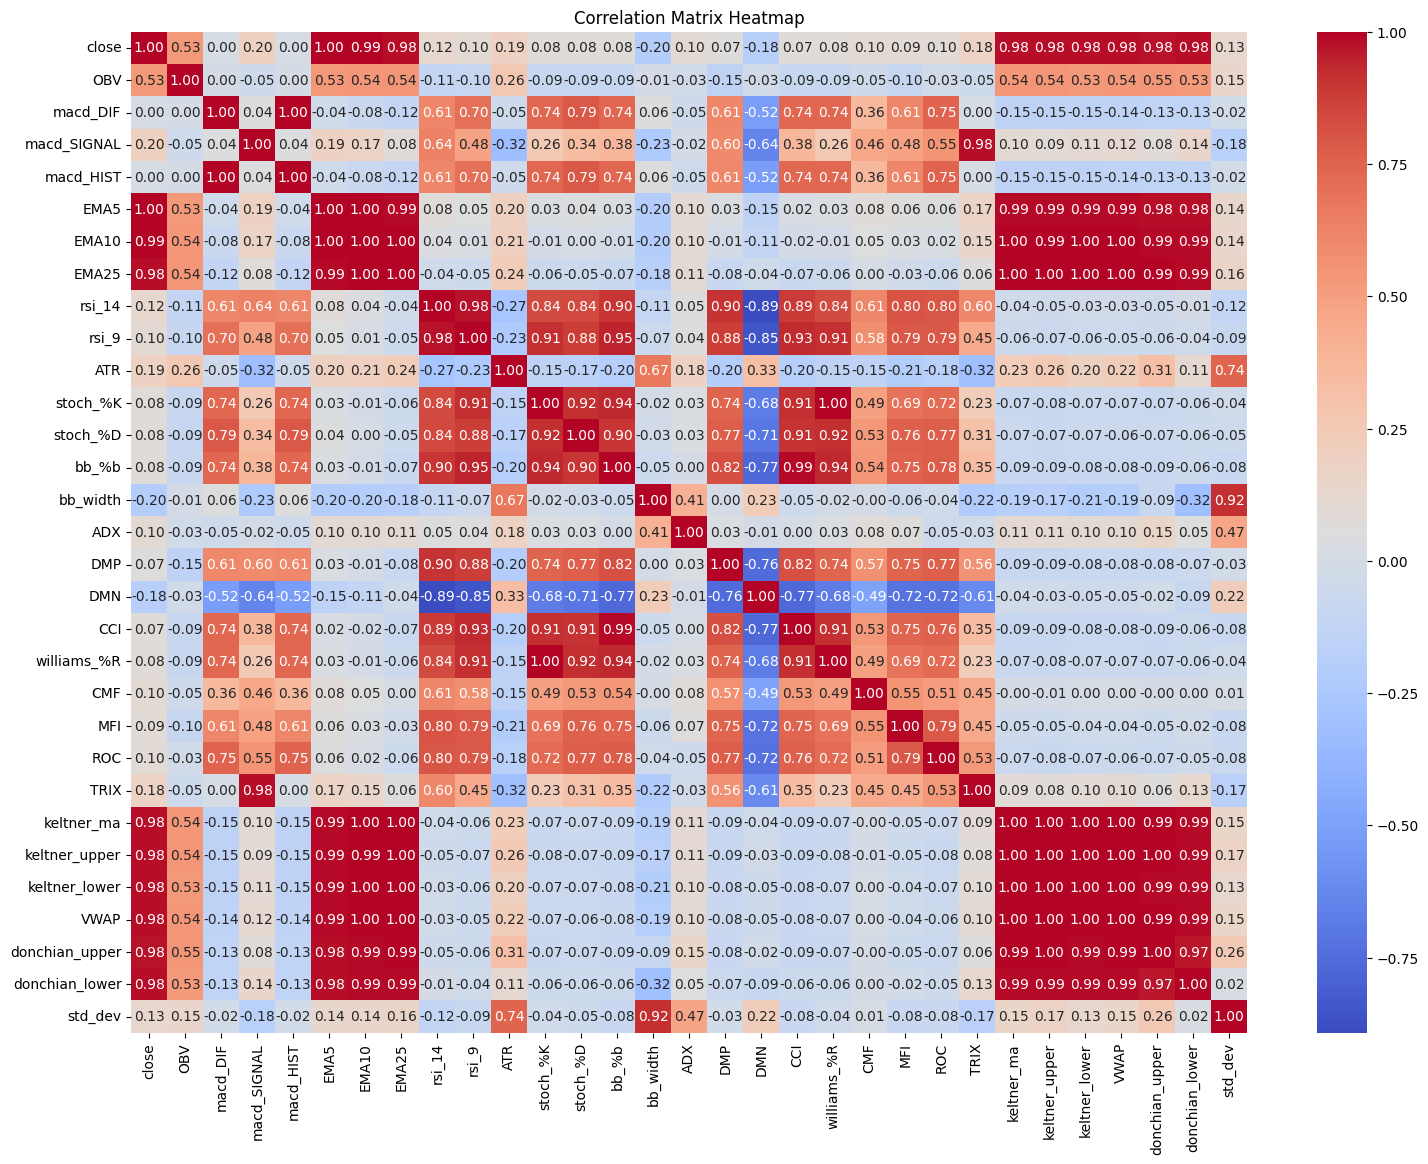

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_correlation(training_data):
    indicators = training_data

    # Calculate the correlation matrix
    correlation_matrix = indicators.corr()
    # Return the correlation matrix
    return correlation_matrix

HANG_SENG_INDEX="^HSI"
training_data = get_stock_data(HANG_SENG_INDEX)

# Get the correlation matrix
training_data = training_data.drop(columns=['open', 'high', 'low', 'volume'])  # Features
correlation_matrix = calculate_correlation(training_data)


# Visualize the correlation matrix
def plot_correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(18, 13))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

# Example usage
plot_correlation_heatmap(correlation_matrix)

### RandomForestRegressor

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

HANG_SENG_INDEX="^HSI"
training_data = get_stock_data(HANG_SENG_INDEX)
# Assuming `training_data` is your DataFrame with features and target
X = training_data.drop(columns=['open', 'high', 'low', 'close', 'volume'])  # Features
y = training_data['close']  # Target

# Time-based split for time series data
split_index = int(len(training_data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
importances = importances / np.sum(importances)  # Normalize importances
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Select top N features
N = 5  # Number of top features to select
top_features = X.columns[indices[:N]]

# Use these top features for your CNN + BiLSTM model
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Print the selected columns
print("\nSelected features:")
print(X_train_selected.columns)

[*********************100%%**********************]  1 of 1 completed


Feature ranking:
1. feature EMA5 (0.9954260121728452)
2. feature rsi_9 (0.0007422600345241979)
3. feature stoch_%K (0.0005482723632537041)
4. feature williams_%R (0.0005412465433570463)
5. feature bb_%b (0.0003529759460299909)
6. feature rsi_14 (0.0002590539104383773)
7. feature CMF (0.00025358150180917636)
8. feature CCI (0.00019559016623074598)
9. feature donchian_upper (0.00018636202377877103)
10. feature OBV (0.00017968482799647758)
11. feature donchian_lower (0.0001567924723858126)
12. feature DMN (0.00014114200320629992)
13. feature DMP (0.00012811915289161235)
14. feature EMA10 (8.341308568451818e-05)
15. feature ATR (7.893579070806836e-05)
16. feature macd_DIF (7.337537700086018e-05)
17. feature macd_HIST (7.191750725409716e-05)
18. feature ROC (7.179810566745747e-05)
19. feature EMA25 (5.3221707846365544e-05)
20. feature TRIX (5.035319939742379e-05)
21. feature ADX (4.815793068466908e-05)
22. feature keltner_lower (4.685009055716471e-05)
23. feature macd_SIGNAL (4.372434043265

### RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Assuming `training_data` is your DataFrame with features and target
X = training_data.drop(columns=['open', 'high', 'low', 'close', 'volume'])  # Features
y = training_data['close']  # Target

# Time-based split for time series data
split_index = int(len(training_data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Initialize the LinearRegression model
lr = LinearRegression()

# Initialize RFE with the LinearRegression model and the number of features to select
n_features_to_select = 15  # Number of top features to select
rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Get the ranking of features
ranking = rfe.ranking_

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print(f"{i + 1}. feature {X.columns[i]} (rank: {ranking[i]})")

# Select the top features
X_train_selected = X_train.loc[:, rfe.support_]
X_test_selected = X_test.loc[:, rfe.support_]

# Print the selected columns
print("\nSelected features:")
print(X_train_selected.columns)

Feature ranking:
1. feature OBV (rank: 16)
2. feature macd_DIF (rank: 1)
3. feature macd_SIGNAL (rank: 1)
4. feature macd_HIST (rank: 1)
5. feature EMA5 (rank: 1)
6. feature EMA10 (rank: 1)
7. feature EMA25 (rank: 1)
8. feature rsi_14 (rank: 1)
9. feature rsi_9 (rank: 1)
10. feature ATR (rank: 13)
11. feature stoch_%K (rank: 1)
12. feature stoch_%D (rank: 1)
13. feature bb_%b (rank: 1)
14. feature bb_width (rank: 7)
15. feature ADX (rank: 9)
16. feature DMP (rank: 1)
17. feature DMN (rank: 2)
18. feature CCI (rank: 10)
19. feature williams_%R (rank: 3)
20. feature CMF (rank: 1)
21. feature MFI (rank: 8)
22. feature ROC (rank: 1)
23. feature TRIX (rank: 1)
24. feature keltner_ma (rank: 4)
25. feature keltner_upper (rank: 5)
26. feature keltner_lower (rank: 6)
27. feature VWAP (rank: 12)
28. feature donchian_upper (rank: 14)
29. feature donchian_lower (rank: 15)
30. feature std_dev (rank: 11)

Selected features:
Index(['macd_DIF', 'macd_SIGNAL', 'macd_HIST', 'EMA5', 'EMA10', 'EMA25',
   